# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD)    (Note: Also called FISTA in the lecture slides!)

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- Since many students are not currently registered on moodle, we are still choosing how you will submit the final notebook. We will e-mail you before **1st of  October** on how to submit the final notebook.
- Deadline for submission is the **4th of october at 21:59**
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "bastien"
ln1 = "billiot"
fn2 = "simon"
ln2 = "demouchy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_billiot_bastien_and_demouchy_simon.ipynb


In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

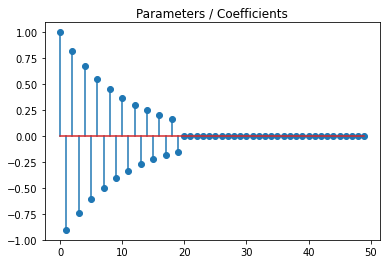

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
import scipy
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [ ]:
A, b = simu_linreg(coefs);
# A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course (using separability) or find a smart way to rewrite it in one line with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [ ]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)  # TODO
    return z

def L1_pen(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.sum(np.abs(x)) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = (1/(1+lmbd)) * np.array(x) #TODO
    return z

def L2_pen(x, lmbd):
    """Value of the L2 penalization at x"""
    return 0.5* lmbd * np.sum(np.array(x)**2) #TODO

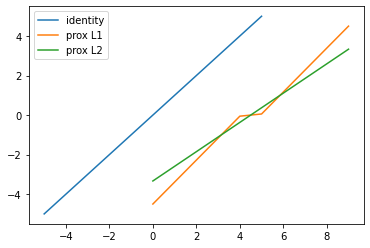

In [ ]:
# Plots TODO
import numpy as np
import matplotlib.pyplot as plt
lmbd = 0.5
X = np.linspace(-5,5,num = 10)
plt.plot(X,X,label='identity')
plt.plot(prox_L1(X, lmbd),label='prox L1')
plt.plot(prox_L2(X, lmbd),label='prox L2')
plt.legend()
plt.show()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plo

(-2.0, 2.0)

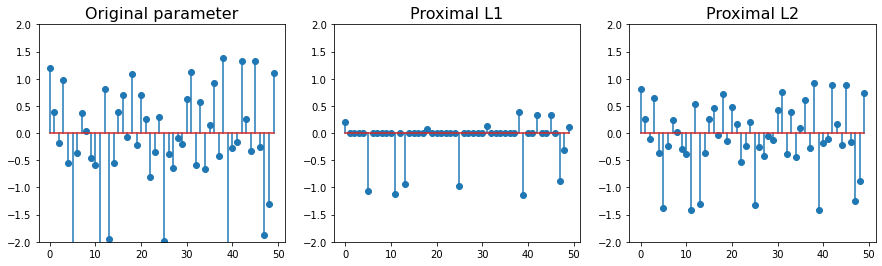

In [ ]:
from numpy.random import randn
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

Both proximal operators (associated with L1 and L2 norm) allows a shrinkage of the parameters to focus on the most relevant ones (as they are regularisators). We observe that the shrinkage of the proximal operator associated with the L1 penalization sets some coefficients to zero (thus providing a feature selection) while the proximal operator associated with the L2 norm only reduces the parameters towards zero. 

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [ ]:
A_linreg, b_linreg = simu_linreg(coefs)
A_logreg, b_logreg= simu_logreg(coefs)
print(A_linreg.shape)
print(A_linreg[1].shape)
print(b_linreg.shape)

(1000, 50)
(50,)
(1000,)


In [ ]:
def f_linreg(x):
    """Least squares loss"""
    s=0
    for i in range(len(b_linreg)):
        s+=(b_linreg[i]-np.dot(A_linreg[i],x))**2
    return s/(2*len(b_linreg))

def grad_f_linreg(x):
    """Least squares gradient"""
    # TODO
    L = []
    for j in range(len(x)):
      s=0
      for i in range(len(b_linreg)):
        s+= A_linreg[i,j] * (np.dot(A_linreg[i],x) - b_linreg[i])
      L.append(s/len(b_linreg))
    return np.array(L)


def f_logreg(x):
    """Logistic loss"""
    s=0
    for i in range(len(b_logreg)):
        s+=np.log(1+np.exp(- b_logreg[i] * np.dot(A_logreg[i],x)))
    return s/(len(b_logreg))

def grad_f_logreg(x):
    """Logistic gradient"""
    L = []
    for j in range(len(x)):
      s=0
      for i in range(len(b_logreg)):
        s+= (- b_logreg[i] * A_logreg[i,j] * np.exp(- b_logreg[i] * np.dot(A_logreg[i],x))) / (1+np.exp(- b_logreg[i] * np.dot(A_logreg[i],x)))
      L.append(s/len(b_logreg))
    return np.array(L)

In [ ]:
import scipy.optimize
from scipy.optimize import check_grad
print(check_grad(f_linreg,grad_f_linreg,b[:50]))
print(check_grad(f_logreg,grad_f_logreg,b[:50]))

2.2467374761216895e-05
2.0908577113226033e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

In [ ]:
# TO BE COMPLETED

from scipy.linalg import svd

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    # TODO
    return np.max(svd(A, full_matrices=False)[1]) ** 2 / A.shape[0] 

# Calculate the smoothness constant for logistic loss    
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    s = 0
    for i in range(A.shape[0]):
      s+= b_logreg[i]**2 * np.sum(A[i] * A[i])
    return s/A_logreg.shape[0]
        
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50, x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    if step is None:
        L = smoothness_const_linreg(A)
        step = 1./L

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        ### Code the update x= x + ???
        x_new[:] = prox_R(x - step * grad_f(x), step)
        x[:] = x_new

        ##############
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [ ]:
# TO BE COMPLETED
""" Also called FISTA in the lecture slides """
def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    beta = 1.
    beta_new = 1. 
    z = x0.copy()
    n_samples, n_features = A.shape

    if step is None:
        L = smoothness_const_linreg(A)
        step = 1./L
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)   
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        ### Code the update of the iterates x and z
        #################
        x_new[:] = prox_R(z - step * grad_f(z), step)
        z[:] = x_new + (beta - 1) / beta_new * (x_new - x)
        beta_new = (1. + (1. + 4. * beta * beta)) ** (0.5) / 2.
        beta = beta_new
        x[:] = x_new

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
prox_L1(np.ones(n_features), 2)

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 100
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [ ]:
APGD(x0, f = f_linreg, grad_f = grad_f_linreg, R = L1_pen, prox_R = prox_L1, step = None, lmbd= lmbd, n_iter = n_iter,
         x_true=coefs, verbose=True)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.54e+00 | 1.00e+00
      10 | 1.54e+00 | 1.00e+00
      20 | 1.54e+00 | 1.00e+00
      30 | 1.54e+00 | 1.00e+00
      40 | 1.54e+00 | 1.00e+00
      50 | 1.54e+00 | 1.00e+00
      60 | 1.54e+00 | 1.00e+00
      70 | 1.54e+00 | 1.00e+00
      80 | 1.54e+00 | 1.00e+00
      90 | 1.54e+00 | 1.00e+00
     100 | 1.54e+00 | 1.00e+00


(array([ 0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,
        -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.,  0., -0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]),
 array([1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54, 1.54,
        1.54, 1.54, 1.54]),
 array([1., 1., 1., 1.

In [ ]:
PGD(x0, f = f_linreg, grad_f = grad_f_linreg, R = L1_pen, prox_R = prox_L1, step = None, lmbd= lmbd, n_iter = n_iter,
         x_true=coefs, verbose=True)

Lauching PGD solver...
   it    |   obj    |   err   
       0 | 1.54e+00 | 1.00e+00
      10 | 1.54e+00 | 1.00e+00
      20 | 1.54e+00 | 1.00e+00
      30 | 1.54e+00 | 1.00e+00
      40 | 1.54e+00 | 1.00e+00
      50 | 1.54e+00 | 1.00e+00
      60 | 1.54e+00 | 1.00e+00
      70 | 1.54e+00 | 1.00e+00
      80 | 1.54e+00 | 1.00e+00
      90 | 1.54e+00 | 1.00e+00
     100 | 1.54e+00 | 1.00e+00


(array([ 0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,
        -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.,  0., -0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]),
 [1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.5392739662478694,
  1.53927396

We don't understand why the two algorithms are not working ..

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

In [ ]:
x_ista, pobj_ista, err_ista = PGD(x0, f = f_linreg, grad_f = grad_f_linreg, R = L1_pen, prox_R = prox_L1, step = None, lmbd= lmbd, n_iter = n_iter,
         x_true=coefs, verbose=True)

x_fista, pobj_fista, err_fista = APGD(x0, f = f_linreg, grad_f = grad_f_linreg, R = L1_pen, prox_R = prox_L1, step = None, lmbd= lmbd, n_iter = n_iter,
         x_true=coefs, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a s

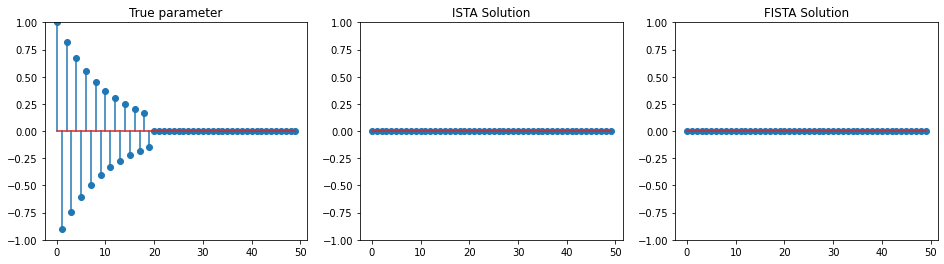

In [ ]:
# Estimated parameters using ISTA, FISTA 
plt.rcParams['figure.figsize'] = (16.0, 4.0)
plt.subplot(1, 3, 1)

plt.stem(coefs)
plt.ylim([-1, 1])
plt.title("True parameter")
plt.subplot(1, 3, 2)
plt.stem(x_ista)
plt.ylim([-1, 1])
plt.title("ISTA Solution")
plt.subplot(1, 3, 3)
plt.stem(x_fista)
plt.ylim([-1, 1])
plt.title("FISTA Solution")
plt.show()

Text(0.5, 1.0, 'Estimation errors')

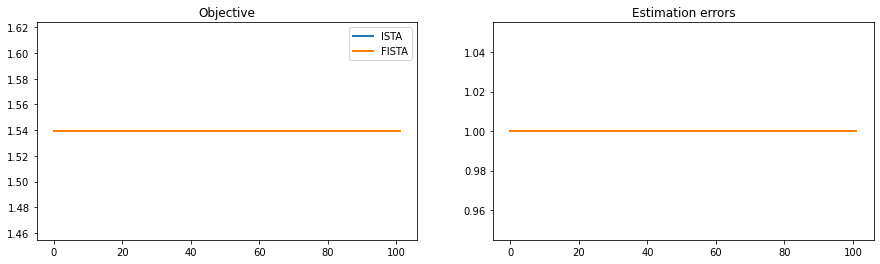

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.plot(pobj_ista, label="ISTA", lw=2)
plt.plot(pobj_fista, label="FISTA", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_ista, label="ISTA", lw=2)
plt.plot(err_fista, label="FISTA", lw=2)
plt.title("Estimation errors")

Influence of the correlation :

In [ ]:
corr = [0.1*i for i in range(1,10)]